In [ ]:
#73c9a156b91f3e0c01c3d5f332d23bfc66f4cdbf

In [1]:
import wandb
wandb.init(project="DoubleDQN22", entity = "rl_proj")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: roysgc (rl_proj). Use `wandb login --relogin` to force relogin


In [ ]:
import gym
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import namedtuple, deque
import time
from ale_py import ALEInterface
import imageio
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from utils_DDQN import *
import os

In [2]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

ale = ALEInterface()

np.random.seed(42)
tf.random.set_seed(42)


config = Config()
best_reward = 0

env = gym.make("Assault-v4") 
n_actions = env.action_space.n

# Creación del modelo y la memoria
model = DQN(n_actions)
model_target = DQN(n_actions)
memory = ReplayMemory(10000)

# Preparación del optimizador y la función de pérdida
optimizer = keras.optimizers.Adam(learning_rate=2.5e-4, clipnorm=1.0)
loss_function = keras.losses.Huber()

episode_rewards = []
losses = []

best_reward = float("-inf")
best_episode = 0
best_frames = []

# Entrenamiento del agente
epsilon = config.EPSILON_START
for episode in range(config.EPISODES):
    #reset_result = env.reset()
    #state = reset_result[0] / 255.0
    #info = reset_result[1]

    state = env.reset() / 255.0
    done = False
    episode_reward = 0
    steps = 0
    info ={'ale.lives': 4, 'episode_frame_number': 2, 'frame_number': 2}

    frames = []
    current_frames = []  # Almacena los frames del episodio actual
    episode_reward = 0

    while not done and  info.get("ale.lives") > 0:
        action = take_action(state, epsilon, env, model)
        
        step_result = env.step(action)
        
        next_state, reward, done, info = step_result

        next_state = next_state / 255.0

        memory.push(state, action, next_state, reward, done)
        #loss = optimize_modelDDQN()
        optimize_modelDDQN(memory, config, model, model_target , n_actions, loss_function, optimizer)

        frame = env.render(mode='rgb_array')
        frames.append(frame)

        state = next_state
        episode_reward += reward

        if reward != 0:
            print("step: ", steps, "action: ", action, " reward: ", reward)
            print("Lives: ", info.get("ale.lives"))

        steps += 1
        
        
        
    print(f"\nEpisodio: {episode+1}, Recompensa: {episode_reward}, Epsilon: {epsilon}")
    
    if episode_reward > best_reward:
        best_reward = episode_reward

        #CAMBIAR PATH a la carpeta doubleDQN
        model.save("./best_DDQN_model", save_format="tf")
        #CAMBIAR PATH a la carpeta doubleDQN
        model_target.save("./best_DDQN_model_target", save_format="tf")
        print("New best model saved")

        gif_path = f"./episode_{episode+1}_reward_{episode_reward}.gif"

        imageio.mimsave(gif_path, frames, fps=30)
    
    episode_rewards.append(episode_reward)
    
    epsilon = max((epsilon * config.EPSILON_DECAY_RATE), config.EPSILON_END)
    
    wandb.log({"episode": episode + 1, "reward": episode_reward, "epsilon":epsilon})
    
   
    
    if (episode + 1) % config.TARGET_UPDATE == 0:
        model_target.set_weights(model.get_weights())


env.close()


step:  110 action:  5  reward:  21.0
Lives:  3
step:  194 action:  4  reward:  21.0
Lives:  3
step:  203 action:  6  reward:  21.0
Lives:  3
step:  227 action:  6  reward:  21.0
Lives:  2
step:  269 action:  2  reward:  21.0
Lives:  1
step:  316 action:  4  reward:  21.0
Lives:  1
step:  397 action:  3  reward:  21.0
Lives:  1
step:  440 action:  0  reward:  21.0
Lives:  1

Episodio: 1, Recompensa: 168.0, Epsilon: 1.0


INFO:tensorflow:Assets written to: ./best_DDQN_model/assets


INFO:tensorflow:Assets written to: ./best_DDQN_model/assets


INFO:tensorflow:Assets written to: ./best_DDQN_model_target/assets


INFO:tensorflow:Assets written to: ./best_DDQN_model_target/assets


New best model saved
1/1 [==============================] - 0s 48ms/step
step:  43 action:  6  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 46ms/step
step:  67 action:  1  reward:  21.0
Lives:  4
step:  95 action:  2  reward:  21.0
Lives:  4
step:  125 action:  1  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 47ms/step
step:  230 action:  1  reward:  21.0
Lives:  4
step:  278 action:  3  reward:  21.0
Lives:  3
step:  317 action:  2  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 48ms/step
step:  359 action:  6  reward:  21.0
Lives:  3
step:  371 action:  2  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 52ms/step
step:  575 action:  2  reward:  21.0
Lives:  1
step:  618 action:  6  reward:  21.0
Lives:  1
step:  673 action:  3  reward:  21.0
Lives:  1
step:  687 action:  5  reward:  21.0
Lives:  1
1/1 [==============================] - 0s 47ms/step

Episodio: 2, Recompensa: 273.0, Epsilon: 0.99


INFO:tensorflow:Assets written to: ./best_DDQN_model/assets


INFO:tensorflow:Assets written to: ./best_DDQN_model/assets


INFO:tensorflow:Assets written to: ./best_DDQN_model_target/assets


INFO:tensorflow:Assets written to: ./best_DDQN_model_target/assets


New best model saved
step:  10 action:  2  reward:  21.0
Lives:  4
step:  19 action:  3  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 45ms/step
step:  109 action:  2  reward:  21.0
Lives:  4
step:  228 action:  3  reward:  21.0
Lives:  3
step:  280 action:  5  reward:  21.0
Lives:  3
step:  288 action:  6  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 50ms/step
step:  435 action:  4  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 46ms/step
step:  473 action:  4  reward:  21.0
Lives:  2
step:  498 action:  3  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 51ms/step
step:  590 action:  5  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 48ms/step
step:  649 action:  6  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 49ms/step
step:  694 action:  5  reward:  21.0
Lives:  2
step:  740 action:  1  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 43ms/step
step: 

INFO:tensorflow:Assets written to: ./best_DDQN_model/assets


INFO:tensorflow:Assets written to: ./best_DDQN_model/assets


INFO:tensorflow:Assets written to: ./best_DDQN_model_target/assets


INFO:tensorflow:Assets written to: ./best_DDQN_model_target/assets


New best model saved
1/1 [==============================] - 0s 254ms/step
step:  55 action:  0  reward:  21.0
Lives:  4
step:  75 action:  6  reward:  21.0
Lives:  4
step:  109 action:  6  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 52ms/step
step:  144 action:  3  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 67ms/step
step:  169 action:  4  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 44ms/step
step:  248 action:  2  reward:  21.0
Lives:  3
step:  307 action:  3  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 45ms/step
step:  368 action:  2  reward:  21.0
Lives:  2
step:  399 action:  0  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 45ms/step
step:  566 action:  6  reward:  21.0
Lives:  1

Episodio: 4, Recompensa: 210.0, Epsilon: 0.9702989999999999
1/1 [==============================] - 0s 45ms/step
step:  15 action:  0  reward:  21.0
Lives:  4
1/1 [==============================] - 

INFO:tensorflow:Assets written to: ./best_DDQN_model/assets


INFO:tensorflow:Assets written to: ./best_DDQN_model/assets


INFO:tensorflow:Assets written to: ./best_DDQN_model_target/assets


INFO:tensorflow:Assets written to: ./best_DDQN_model_target/assets


New best model saved
1/1 [==============================] - 0s 42ms/step
step:  21 action:  1  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 52ms/step
step:  85 action:  6  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 55ms/step
step:  101 action:  6  reward:  21.0
Lives:  4
step:  118 action:  4  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 54ms/step
step:  158 action:  5  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 56ms/step
step:  167 action:  3  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 61ms/step
step:  253 action:  6  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 40ms/step
step:  290 action:  0  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 47ms/step
step:  381 action:  2  reward:  21.0
Lives:  3
step:  387 action:  5  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 58ms/step
step:  490 action:  2  reward:  21.0
Lives:

KeyboardInterrupt: 

In [3]:
model.save("./last_DDQN_model", save_format="tf")        
model_target.save("./last_DDQN_model_target", save_format="tf")

INFO:tensorflow:Assets written to: ./last_DDQN_model/assets


INFO:tensorflow:Assets written to: ./last_DDQN_model/assets


INFO:tensorflow:Assets written to: ./last_DDQN_model_target/assets


INFO:tensorflow:Assets written to: ./last_DDQN_model_target/assets


In [4]:
# Access the reward range
min_reward, max_reward = env.reward_range

# Print the range
print(f"Minimum Reward: {min_reward}")
print(f"Maximum Reward: {max_reward}")

Minimum Reward: -inf
Maximum Reward: inf


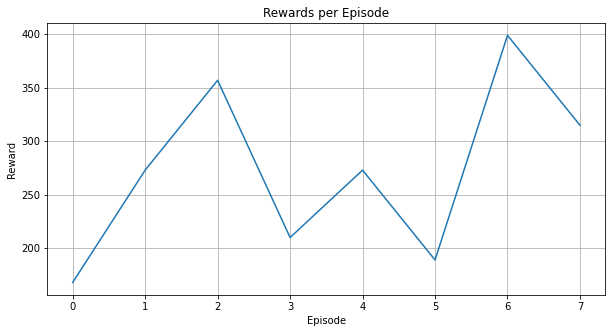

In [5]:
plot_rewards(episode_rewards)


1/1 [==============================] - 0s 37ms/step
action:  3  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 22ms/step
action:  4  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 24ms/step
action:  0  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 20ms/step
action:  1  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 26ms/step
action:  3  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 20ms/step
action:  4  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 21ms/step
action:  3  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 24ms/step
action:  1  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 21ms/step
action:  3  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 20ms/step
action:  3  reward:  21.0
Lives:  1
1/1 [==============================] - 0s 24ms/step
Episode 1: Reward = 210.0
1/1 [==============================] - 0s 

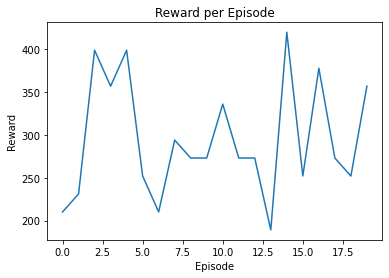

In [5]:
#TEST THE SAVED MODEL
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import imageio

# Carga los modelos
#CAMBIAR PATH A DONDE ESTA EL MODELO
model = keras.models.load_model("./best_DDQN_model")

#CAMBIAR PATH A DONDE ESTA EL MODELO
model_target = keras.models.load_model("./best_DDQN_model_target")

# Crea el entorno
env = gym.make("Assault-v4")
n_actions = env.action_space.n

epsilon = 0.9227

rewards_per_episode = []
best_reward = 0

for episode in range(20):
    state= env.reset()
    state = state / 255.0  
    done = False
    episode_reward = 0
    frames = []
    info ={'ale.lives': 4, 'episode_frame_number': 2, 'frame_number': 2}

    while not done:
        action = take_action_test(state)
        next_state, reward, done, info = env.step(action)
        next_state = next_state / 255.0  

        frame = env.render(mode='rgb_array')
        frames.append(frame)

        state = next_state
        episode_reward += reward

        if reward != 0:
            print("action: ", action, " reward: ", reward)
            print("Lives: ", info.get("ale.lives"))
        
        #steps += 1

    rewards_per_episode.append(episode_reward)
    print(f"Episode {episode + 1}: Reward = {episode_reward}")

    if episode_reward > best_reward:
        best_reward = episode_reward 
        
        gif_path = f"./test_episode_{episode+1}_reward_{episode_reward}.gif"
        imageio.mimsave(gif_path, frames, fps=30)

    # Log episode metrics and GIF to wandb
    wandb.log({"episode": episode + 1, "reward": episode_reward, "epsilon": epsilon, "episode_gif": wandb.Video(gif_path, fps=4, format="gif")})


env.close()

# Grafica las recompensas por episodio
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.show()